<a href="https://colab.research.google.com/github/Valiev-Koyiljon/Multiclass-weather-classification-Pytorch/blob/main/Multiclass_weather_classification_CNN_Koyiljon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images of  Multi-class Weather Dataset using Pytorch Framework 


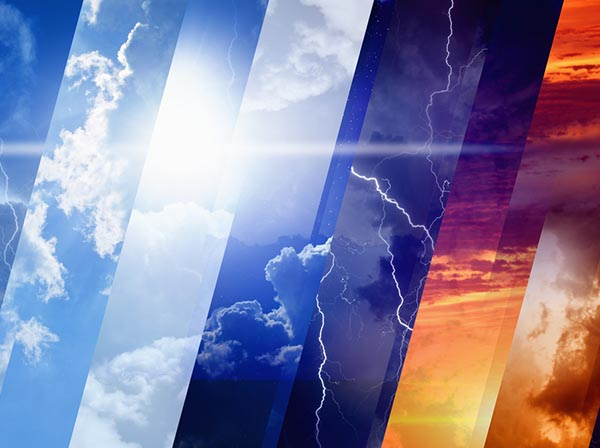

##**Title**: Weather Condition Recognition with Deep Learning



**Description**:
For our computer vision final project, we focused on training a deep learning model to recognize weather conditions from single images. To accomplish this, we leveraged the multi-class weather dataset available on Kaggle, specifically the "Multiclass Images for Weather Classification" dataset (link: https://www.kaggle.com/datasets/somesh24/multiclass-images-for-weather-classification).

This dataset provided us with a diverse collection of 1125 labeled images, each representing a specific weather condition such as sunny, cloudy, rainy, snowy, or foggy. We utilized the PyTorch framework to build and train a convolutional neural network (CNN) model.

To ensure optimal performance, we performed necessary preprocessing steps on the dataset, including resizing, normalization, and potentially augmentation techniques. These preprocessing steps help improve the model's ability to generalize and accurately classify weather conditions from unseen images.

With our CNN model architecture in place, we trained the model using appropriate loss functions and optimization algorithms. The training process involved feeding the preprocessed images into the model and iteratively adjusting the model's parameters through forward and backward propagation.

To evaluate the effectiveness of our trained model, we conducted rigorous testing using a separate subset of the dataset. We measured performance metrics such as accuracy and loss to assess the model's ability to correctly classify weather conditions.

While we did not deploy the model in a real-time application, our focus was on the development and training phases of the deep learning model. By successfully training a model that achieves high accuracy in weather condition recognition, we have demonstrated our proficiency in computer vision and deep learning techniques.

Overall, our project showcases the potential of deep learning in weather classification tasks and provides a solid foundation for further exploration and potential future deployments.

Let's get started by importing some necessary libraries.

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile


# Multi-Class Weather Data Preprocessing

Firstly, we need to download the dataset and extract it. You can access my google drive and download the dataset from the link: [Datase link](https://drive.google.com/file/d/1sVJ4Y5zhMgj2dlyWHecdrMxNB3djisFT/view?usp=sharing). After you acces to the file, download the file and upload it your google drive

In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Secondly, we run the folloing code to unzip dataset and save it on our (specific path) google drive


In [ ]:
import zipfile

# Read the zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/dataset/multi-class-weather-dataset.zip', 'r')


# Unzip the zip file and save it on the google drive you want.
zip_ref.extractall('/content/drive/MyDrive/MyDataset') 
zip_ref.close()




Let's look into the data folder.

In [ ]:
data_dir = '/content/drive/MyDrive/MyDataset'
print(os.listdir(data_dir))

['train', 'test']


So, we have two directories called "train" and "test" containing the training and the testing images for the model. Let's check how many output classes it contains.

In [ ]:
classes = os.listdir(data_dir + "/train")
print(classes)

['cloudy', 'rain', 'shine', 'sunrise']


We have 4 output classes referring to four weather conditions. Now, let's see how many images we have in the training set, test set and in each output class for training and test.

In [ ]:
# training imageset
count = 0
dirc = 0
print("Train Image directory:\n")
for root, dirs, files in os.walk(data_dir + '/train'):


    # Calculating and displaying the number of images in each class
    if files:
        file_count = len(files)
        print("'{}' : {}".format(classes[dirc], file_count))
        dirc += 1


    # Total number of train images
    count += len(files)


train_len = count
print("\nTrain Set:", train_len)  # Training images


Train Image directory:

'cloudy' : 275
'rain' : 190
'shine' : 228
'sunrise' : 332

Train Set: 1025


In [ ]:
# test imageset
count = 0
dirc = 0
print("Test Image Directory:\n")
for root, dirs, files in os.walk(data_dir + '/test'):


    # Calculating and displaying the number of images in each class
    if files:
        file_count = len(files)
        print("'{}' : {}".format(classes[dirc], file_count))
        dirc += 1


    # Total number of testing images
    count += len(files)


test_len = count
print("\nTest Set:", test_len)  # Test images


Test Image Directory:

'cloudy' : 25
'rain' : 25
'shine' : 25
'sunrise' : 25

Test Set: 100


In [ ]:
# Total image size
print("We  have total: ", train_len + test_len, "images")

We  have total:  1125 images


**Note:** We can see the image distribution in the training set is odd but even for the test set.

###Let's check the shape and size of some of our images.

In [ ]:
# We can use the ImageFolder class from torchvision to load the data as PyTorch tensors
img_size = ImageFolder(data_dir, tt.ToTensor())
len(img_size)

1125

In [ ]:
# Shape of few images in our dataset
img,_ = img_size[53]
print(img.shape)
img,_ = img_size[404]
print(img.shape)
img,_ = img_size[775]
print(img.shape)
img,_ = img_size[1058]
print(img.shape)
img,_ = img_size[1120]
print(img.shape)

torch.Size([3, 177, 284])
torch.Size([3, 300, 400])
torch.Size([3, 480, 320])
torch.Size([3, 153, 203])
torch.Size([3, 168, 300])


As you can see,  we have different image shapes across the training and test sets. 
So, we need to resize all our images to prevent any complications or problems later.
Let's start by finding the minimum and maximum height and width of our images.

In [ ]:
height = []
width = []
for image,_ in img_size:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}\nmaximum height: {}\nminimum width: {}\nmaximum width: {}".format(min(height), max(height), min(width), max(width)))

minimum height: 94
maximum height: 3195
minimum width: 158
maximum width: 4752


### Data transforms (normalization & data augmentation)


We will apply the following changes to our image : 
*   *Resizing* our images to `94px x 94px`.
*   *Test set as our validation set* to make our model more familiar with the data and enhance its performance.
*   *Channel-wise data normalization* by subtracting the mean and dividing by the standard deviation across each channel to bring the pixels in the range of `-1 to 1` to prevent values of one channel from disproportionately affecting the losses and gradients while training.
*   *Randomized data augmentations* to make our model generalize better by flipping,padding, and so on.




In [ ]:
# statistics for normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
stats = (mean, std)

# Resize images to 94px x 94px
image_size = (94, 94)


# Use the test set as our validation set for better performance
valid_transforms = tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(mean=mean, std=std)
])


# Normalize the data channel-wise to range from -1 to 1
normalize_transforms = tt.Normalize(mean=mean, std=std)



# Apply randomized data augmentations for better generalization
train_transforms = tt.Compose([
    tt.Resize(image_size),
    tt.RandomCrop(image_size, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    normalize_transforms
])


In [ ]:
# our train and validation dataset
train_ds = ImageFolder(data_dir+'/train', train_transforms)
valid_ds = ImageFolder(data_dir+'/test', valid_transforms)

In [ ]:
# Shape of few images in our dataset
img,_ = train_ds[50]
print(img.shape)
img,_ = train_ds[400]
print(img.shape)
img,_ = train_ds[750]
print(img.shape)
img,_ = valid_ds[30]
print(img.shape)
img,_ = valid_ds[70]
print(img.shape)

torch.Size([3, 94, 94])
torch.Size([3, 94, 94])
torch.Size([3, 94, 94])
torch.Size([3, 94, 94])
torch.Size([3, 94, 94])


Hence, we can see all the images in our datasets are resized to the same size. Since the data consists of 94x94 px color images with 3 channels (RGB), each image tensor has the shape (3, 94, 94).

we will see some of our normalized images in the code below:

In [ ]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

**img.permute(1, 2, 0)** - rearranges the dimensions of the image tensor to match the expected format for **plt.imshow()**, which is (**height, width, channels**). The **permute()** function is used to transpose the dimensions of the tensor, converting it from the PyTorch tensor format (**channels, height, width**) to the expected format.

**img.permute(1, 2, 0)** indicates that the original second dimension of the tensor becomes the first dimension of the transposed tensor, the original third dimension becomes the second dimension, and the original first dimension becomes the third dimension. This ensures that the image tensor is in the format expected by plt.imshow().

Finally, **plt.imshow()** displays the image on the screen using the transposed tensor.

Label:  cloudy (0)


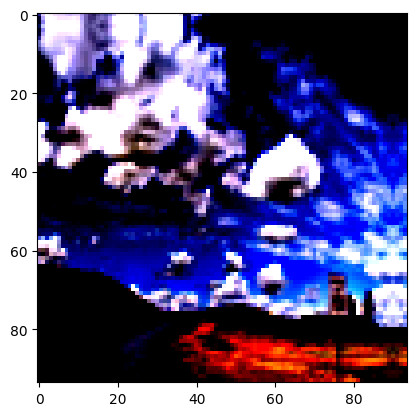

In [ ]:
show_example(*train_ds[45])

Label:  rain (1)


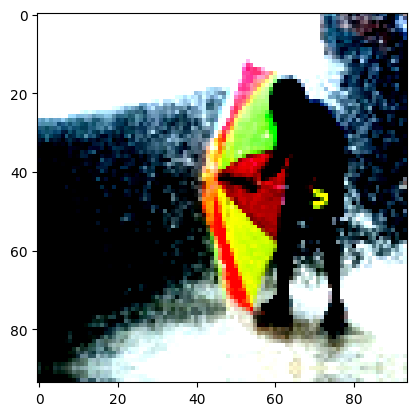

In [ ]:
show_example(*train_ds[355])

Label:  sunrise (3)


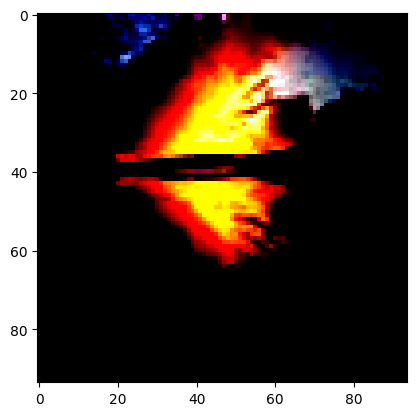

In [ ]:
show_example(*valid_ds[93])

###How do we choose batch_size?

Choosing the batch size involves considering **memory constraints**, **computational efficiency**, **dataset size**, and **generalization**. It is a trade-off between training time and model performance. Smaller batch sizes introduce more *randomness and can prevent overfitting*, while larger batch sizes leverage *parallel processing for faster training*. The ideal batch size varies depending on the specific task and hardware, typically ranging from 
 32-128 samples. Experimentation is necessary to find the optimal balance.

Next, we can create data loaders for retrieving images in batches. We'll use a batch size of 32. 

In [ ]:
batch_size = 32


Next, we create data loaders and make **num_workers=2**, which specifies the number of worker processes to use for data loading. Using multiple workers can speed up data loading by loading multiple batches in parallel.


Then, we make **pin_memory=True**, which enables pinned memory, which allows faster data transfer between CPU and GPU memory when using a GPU. This can improve training speed if you are using a GPU.

In [ ]:
# data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values in order to bring them back into the range (0,1).

In [ ]:
# function to denormalize image
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


# function to see batches
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

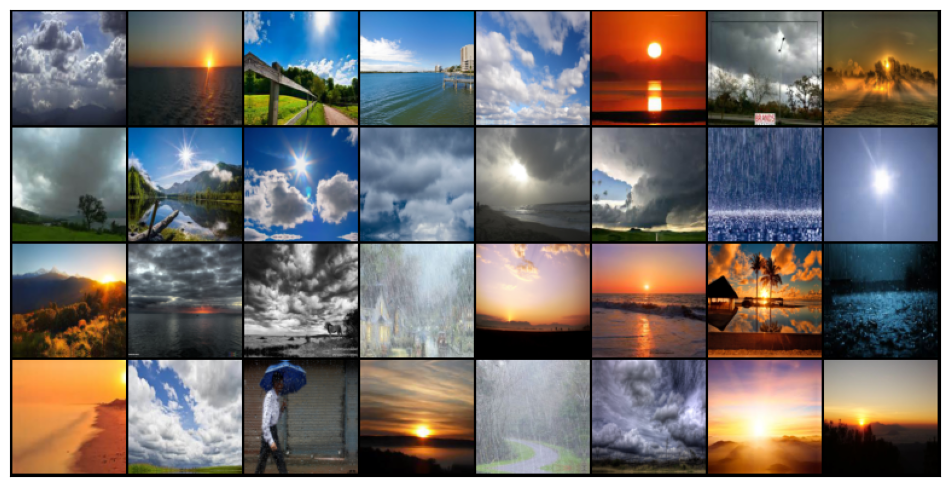

In [ ]:
show_batch(train_dl)

## Using a CUDA (GPU)

GPU boasts of superior parallel computation power than CPU and is highly used when doing classificaton problems to train models faster. To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
# to check that we are using CPU or GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [ ]:
# DeviceDataLoader class to move our model & data to the GPU as required
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Let's check whether we are using a CPU or GPU
device = get_default_device()
device

device(type='cpu')

 Now, GPU is enabled and so we can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### We will use **ResNet9**, which is a CNN architecture 

We will be implementing a Convolutional Neural Network (CNN) architecture called ResNet9. This architecture includes a special building block called the residual block, which combines the original input with the output of one or more convolutional layers.

By incorporating the residual block, we can achieve significant improvements in the model's performance. Additionally, after each convolutional layer, we will include a batch normalization layer, which helps normalize the outputs of the previous layer.

ResNet9 consists of a total of 8 convolutional layers, 8 Rectified Linear Unit (ReLU) layers for introducing non-linearity, 3 MaxPool layers for downsampling, 1 Flatten layer to convert the output into a 1-dimensional vector, and 1 Dropout layer for regularization. This architecture is effective in mitigating issues such as **overfitting**, which can occur when a model becomes too specialized to the training data.

In summary, ResNet9 is a CNN architecture that leverages the power of residual blocks and batch normalization to enhance model performance. It includes several convolutional and ReLU layers, along with pooling, flattening, and dropout layers, which collectively contribute to better generalization and can help prevent overfitting.

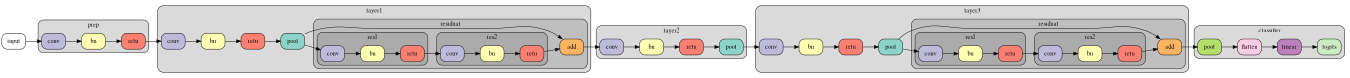

In [ ]:
# function to calculate the accuracy
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    accuracy = torch.sum(preds == labels).item() / len(preds)
    return torch.tensor(accuracy)


# class for image classification part of our project
class ImageClassificationBase(nn.Module):

  # function for training images
    def training_step(self, batch):
        images, labels = batch 
        outputs = self(images) # Get predicted output
        loss = F.cross_entropy(outputs, labels) # Calculate loss
        return loss
    


    # function to calculate the validation loss and accuracy
    def validation_step(self, batch):
        images, labels = batch 
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels) # Calculate loss
        acc = accuracy(outputs, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        # Calculate average validation loss
        val_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.mean(torch.stack(val_losses))
        
        
        # Calculate average validation accuracy
        val_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.mean(torch.stack(val_accs))
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        last_lr = result['lrs'][-1]
        train_loss = result['train_loss']
        val_loss = result['val_loss']
        val_acc = result['val_acc']
        

        # epoch summary
        print(f"Epoch [{epoch}], last_lr: {last_lr:.5f}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")


In [ ]:
# a convolutional block
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


# The ResNet9 model
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # The layers for feature extraction
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        # The classifier layers
        self.classifier = nn.Sequential(
            nn.MaxPool2d(11),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )


# function to make forward in backpropogation
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [ ]:
# changing our device(cpu to gpu if cuda available)
model = to_device(ResNet9(3, 4), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

* **Learning rate scheduling:** Instead of using a fixed learning rate, we will use a 
learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the *One Cycle Learning Rate Policy*, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

* **Weight decay:** We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

* **Gradient clipping:** Apart from the layer weights and outputs, it is also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

Let's define a fit_one_cycle function to incorporate these changes. We'll also record the learning rate used for each batch.

In [ ]:
@torch.no_grad()

#  Evaluates the model on the validation set.
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


#  Retrieves the current learning rate from the optimizer.
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



# Trains the model using the one-cycle learning rate policy
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step() # to update
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# record the learning rate , validation accuracy and validation loss 
history = evaluate(model,valid_dl)
history

{'val_loss': 1.3949252367019653, 'val_acc': 0.171875}

We're now ready to train our model. We'll be using the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training.

In [ ]:
epochs = 17
max_lr = 0.01
grad_clip = 0.1 
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, 
                        weight_decay=weight_decay, 
                        opt_func=opt_func)


Epoch [0], last_lr: 0.00124, train_loss: 0.8340, val_loss: 2.7043, val_acc: 0.6328
Epoch [1], last_lr: 0.00355, train_loss: 0.4791, val_loss: 8.4782, val_acc: 0.3594
Epoch [2], last_lr: 0.00648, train_loss: 0.6342, val_loss: 0.8139, val_acc: 0.8828
Epoch [3], last_lr: 0.00893, train_loss: 0.6950, val_loss: 19.3056, val_acc: 0.4219
Epoch [4], last_lr: 0.00999, train_loss: 0.8294, val_loss: 1.2504, val_acc: 0.7500
Epoch [5], last_lr: 0.00986, train_loss: 0.8607, val_loss: 5.1228, val_acc: 0.3984
Epoch [6], last_lr: 0.00938, train_loss: 0.9374, val_loss: 0.9482, val_acc: 0.8672
Epoch [7], last_lr: 0.00860, train_loss: 0.4757, val_loss: 0.6885, val_acc: 0.8594
Epoch [8], last_lr: 0.00758, train_loss: 0.4574, val_loss: 0.7885, val_acc: 0.8359


In [ ]:
train_time='3:23'

Our model trained to over 92% accuracy after 17 epochs in under 3 minutes 23 s! 

Let's plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

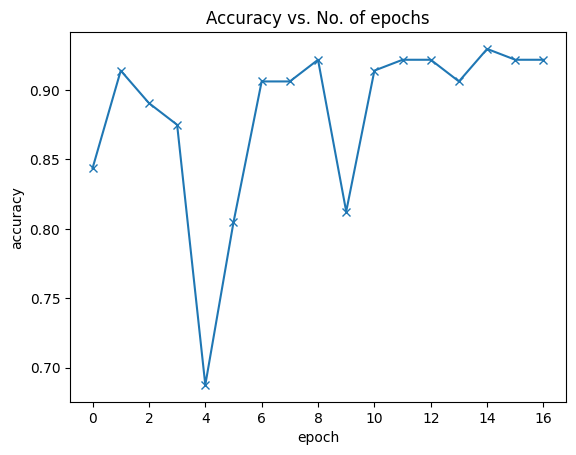

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

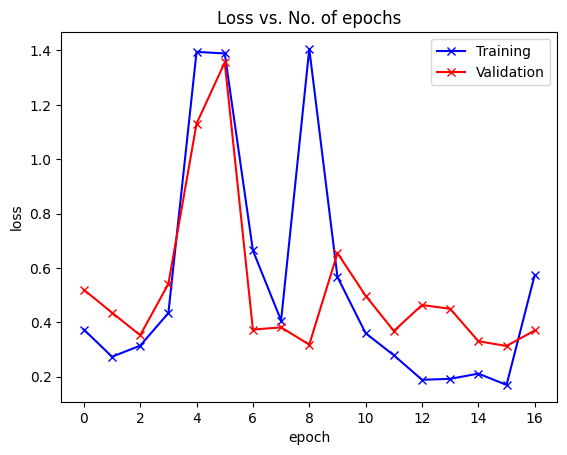

In [ ]:
plot_losses(history)

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

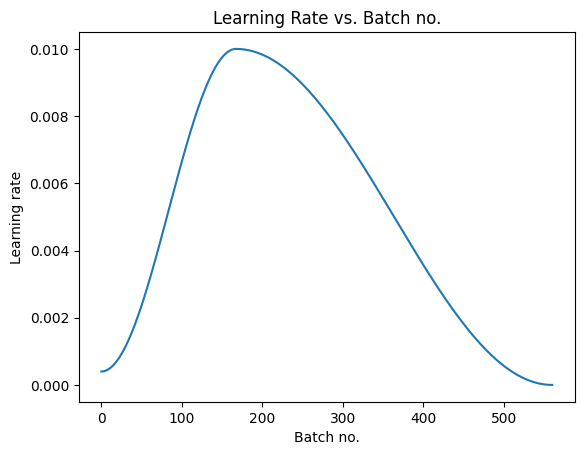

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

# Testing with individual images

Now it's time to test out our model with some images from the predefined test dataset of 100 images.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: cloudy , Predicted: cloudy


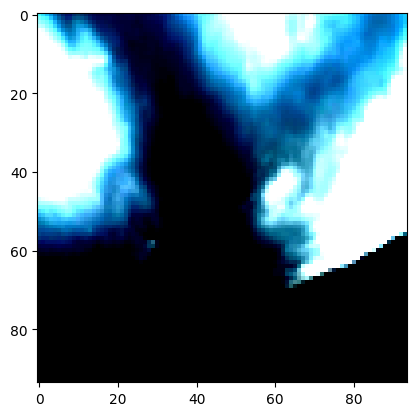

In [ ]:
img, label = valid_ds[4]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: rain , Predicted: rain


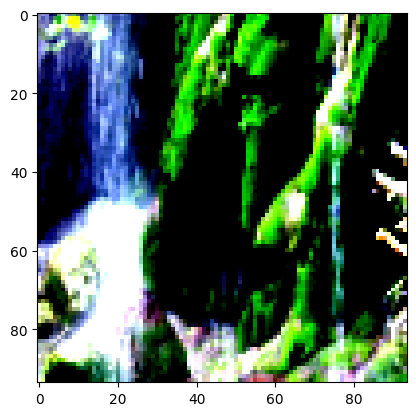

In [ ]:
img, label = valid_ds[42]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: shine , Predicted: shine


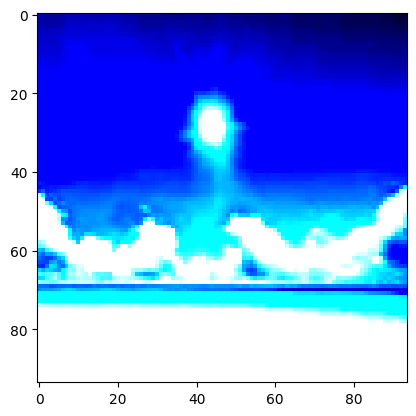

In [ ]:
img, label = valid_ds[64]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: sunrise , Predicted: sunrise


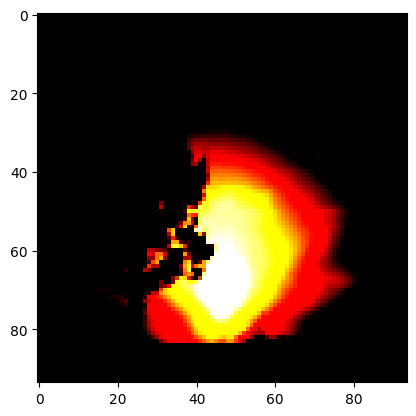

In [ ]:
img, label = valid_ds[90]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: sunrise , Predicted: sunrise


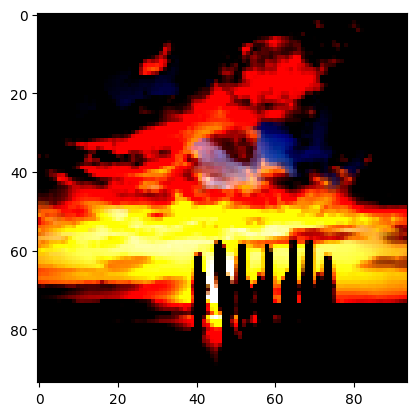

In [ ]:
img, label = valid_ds[97]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Saving our model part

Now, we save the weights of the model

In [ ]:
torch.save(model.state_dict(), '/content/multiclass-weather-classification-resnet9.pth')

Download the saved model from google colab

In [ ]:
from google.colab import files
files.download('/content/multiclass-weather-classification-resnet9.pth')


# Conclusion

Finally, we achieve an accuracy of over 92% with the ResNet9 model for weather image classification. The success of our model can be attributed to the implementation of various advanced techniques, including normalization, data augmentation, regularization, and residual connections. These techniques have effectively improved the model's generalization capabilities and prevented overfitting. By training the model from scratch and documenting our lines of code with great comments, we have achieved to detect weather by using the single image.